
# Лабораторная работа №4 
## Супонина Анастасия
## группа: НПМмд-01-24

# "Исследование моделей размещения пользователей и распространения сигнала"

### Цель - исследовать сценарий размещения пользователей на плоскости и рассчитать вероятность блокировок прямой видимости. 

## Задание. 

Построить согласно описанному ниже алгоритму имитационную модель, позволяющую рассчитать вероятность блокировки линии прямой видимости, и сравнить полученную характеристику с результатами математической модели.

1. В квадратной области со стороной А согласно точечному Пуассоновскому процессу с плотностью q разместить объекты (окружности с фиксированным радиусом r), которые могут заблокировать линию прямой видимости между двумя точками, размещенными на расстоянии x друг от друга внутри обозначенной области. Проверить блокирует ли хотя бы один объект линию прямой видимости.
2. Количество блокирующих объектов определяется согласно распределению Пуассона с параметром $ qA^2 $, а объекты вбрасываются независимо друг от друга. При этом центры блокирующих объектов должны быть распределены равномерно внутри рассматриваемой области.

На основе описанного выше алгоритма получить 1000 реализаций факта блокировки линии прямой видимости и рассчитать вероятность блокировки линии прямой видимости в поле блокирующих объектов. Полученный результат сравнить с результатами математической модели.

Для начала работы ввожу необходимые библиотеки:

    - numpy # для рандомной генерации чисел с различными распределениями и др.
    - matplotlib.pyplot # для построения графиков
    
И также отдельно для краткости написания ввожу функции из библиотеки numpy, такие как

    - norm # вычисляет норму матрицы или вектора
    - arccos
    - dot # вычисляет скалярное произведение
    - pi
    - cross
    - cos
    - sin

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import arccos, dot, pi, cross, cos, sin

Задаю основные парметры:

In [46]:
guard_size = 10 # размер квдратной области
poisson_lam_block = 0.3 # плотность с которой будут возникать блокаторы
radius_block = 0.5 # значение радиуса блокатора
distance_Tx_Rx = 3 # расстояние между передатчиком и приемником
list_point = np.array # переменная(массив) для записи точек

Рисую круг при помощи формулы окружности через угловые значения

In [47]:
# Рисуем круг
def plot_circle(x, y, r):
    angles = np.linspace(0, 2*pi, 50)
    x_cir = x + r*cos(angles)
    y_cir = y + r*sin(angles)
    plt.plot(x_cir, y_cir, 'red')

Создаю функцию для точечного Пуассоновского процесса, а именно при помощи random.poisson генерирую случайные значения с Пуассоновским распределением в количестве равном $ qA^2 $
Также задаем координаты центров окружностей с равномерным распределением

In [48]:
# Инициализация Пуассоновского точечного процесса
def poisson_point_process(lambda0, area_size):
    Number_block = np.random.poisson(lambda0 * area_size ** 2) 
    x = np.random.uniform(0, area_size, size = Number_block) 
    y = np.random.uniform(0, area_size, size = Number_block) 
    return x,y 

Создаю функцию которая при помощи координат двух точек и известного угла, строит прямоугольную область. Для этого мы из заданного угла получаем 3 других.

Из которых основными являеются:
    
    - reverse_angle # используется для определения положения одной из сторон прямоугольника вокруг отрезка
    - opposite_angle # помогает определить другую сторону прямоугольника вокруг отрезка
    
И используя функции sin и cos расситываю четыре угла прямоугольника, окружающего линию между двумя точками.

При помощи которых вычисляю значения x и y, для каждой из вершин.

In [49]:
# Функция для прямоугольника вокруг линии прямой видимости 
def paint_rectangle(x_point_1, y_point_1, x_point_2, y_point_2, angle): 
    difference_angle = 2 * pi - angle # угол поворота
    reverse_angle = pi/2 - difference_angle # перпендикулярный угол к углу поворота
    opposite_angle = reverse_angle + pi # противоположный угол для перпендикулярного
    x_rectang_A = x_point_1 + radius_block * cos(opposite_angle) 
    y_rectang_A = y_point_1 + radius_block * sin(opposite_angle)
    x_rectang_B = x_point_1 + radius_block * cos(reverse_angle)
    y_rectang_B = y_point_1 + radius_block * sin(reverse_angle)
    x_rectang_C = x_point_2 + radius_block * cos(reverse_angle)
    y_rectang_C = y_point_2 + radius_block * sin(reverse_angle)
    x_rectang_D = x_point_2 + radius_block * cos(opposite_angle) 
    y_rectang_D = y_point_2 + radius_block * sin(opposite_angle)
    
    return x_rectang_A, y_rectang_A, x_rectang_B, y_rectang_B, x_rectang_C, y_rectang_C, x_rectang_D, y_rectang_D

Пишу функцию, которая будет находит расстояния от точки до векторов.
Находим нормальные вектора и проверяем значения угла между двумя векторами fi, если угол больше 90 градусов или arccos больше 1, то это означает, что точка С находиться ближе к точке А и мы вычисляем и записываем эту дистанцию как наименьшую, аналогично проверяем для В и в ином случае если не одно из предыдущих условий не выполнилось, то это означает, что точка С находится между точками А и В, а значить для получения наимешьшего рассторяния нам нужно нужно вычислить перпендикулярный вектор до прямой АВ.

In [50]:
def check_distance(A, B, C):
    CA = (C - A) / norm(C - A) 
    BA = (B - A) / norm(B - A) 
    CB = (C - B)/norm(C - B) 
    AB = (A - B) / norm(A - B) 
    if arccos(dot(CA, BA)) > 1: 
        return norm(C - A) 
    if arccos(dot(CB, AB)) > 1: 
        return norm(C - B) 
    return norm(cross(A - B, A - C)) / norm(B - A)

Создаю функцию которая будет определять пересечение блокаторов с линией связи(линией прямой видимости). Она считает длины векторов от точки до нашей прямой и мы сравниваем каждое расстояние с нашим радиусом и если значение меньше, то блокатор пересекается с сигналом, таким образом блокируя его.

In [51]:
def crossing(): 
    circle_point = []; 
    point_1 = []; 
    point_2 = []; 
    point_1.extend([x1, y1]) 
    point_2.extend([x2, y2]) 
    for i in range(len(x)): 
        circle_point.append([x[i], y[1]]) 
    for i in range(len(x)): 
        if (np.round(check_distance(list_point(point_1), list_point(point_2), list_point(circle_point[i])), 1) <= radius_block): 
            return True

Переходим к отображению на графике, вычисляя все значения при помощи ранее созданных функций. Задаем случайную начальную точки и угол, и также задаем значение при помощи формулы второй точки.

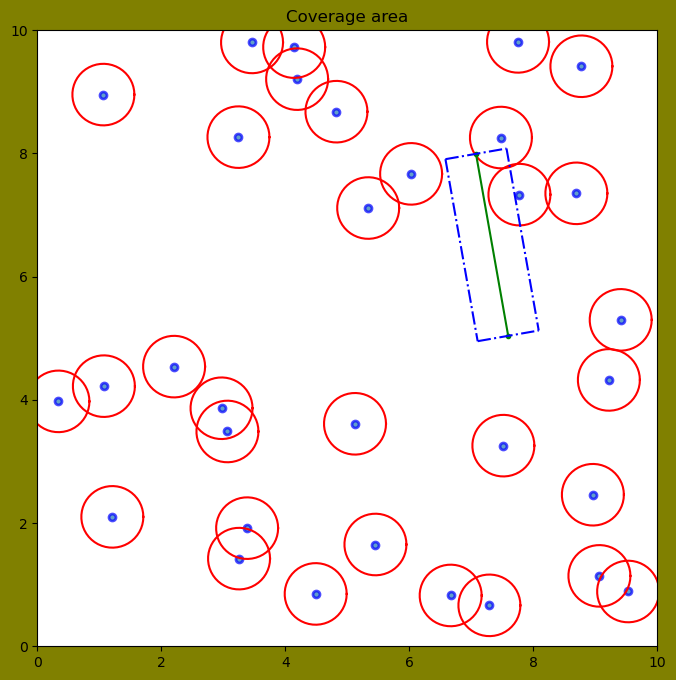

In [54]:
x, y = poisson_point_process(poisson_lam_block,guard_size) 
x1 = np.random.uniform (0,guard_size) 
y1 = np.random.uniform (0,guard_size) 
angle = np.random.uniform (0,2*pi) 
x2 = x1 + distance_Tx_Rx * cos(angle) 
y2 = y1 + distance_Tx_Rx * sin(angle) 
x_rectang_A, y_rectang_A, x_rectang_B, y_rectang_B, x_rectang_C, y_rectang_C, x_rectang_D, y_rectang_D = paint_rectangle(x1, y1, x2, y2, angle)

plt.figure(dpi=100, figsize=(8, 8), facecolor='olive')
plt.title('Coverage area')
plt.plot(x, y, '.', alpha=0.7, label="first", lw=5, mec = 'b', mew=2, ms=10) 
for i in range(len(x)): 
    plot_circle(x[i], y[i], radius_block)  # функция рисующая круги
plt.plot([x1,x2], [y1,y2], '.-g') 

# функция рисующая зону блокировки вокруг линии прямой видимости
plt.plot([x_rectang_A, x_rectang_B], [y_rectang_A, y_rectang_B], '-.b') 
plt.plot([x_rectang_A, x_rectang_D], [y_rectang_A, y_rectang_D], '-.b') 
plt.plot([x_rectang_B, x_rectang_C], [y_rectang_B, y_rectang_C], '-.b') 
plt.plot([x_rectang_D, x_rectang_C], [y_rectang_D, y_rectang_C], '-.b') 
plt.xlim(0,guard_size) 
plt.ylim(0,guard_size) 
plt.show()

In [55]:
# События блокировки
if (crossing()):
    print('LoS blocked')
else:
    print('LoS in not blocked')

LoS blocked


На основе описанного выше алгоритма получаю 1000 реализаций факта блокировки линии прямой видимости и рассчитываю вероятность блокировки линии прямой видимости в поле блокирующих объектов. 

In [56]:
# Имитационное моделирование 
N = 1000 #param (type: "integer"} 
summa = 0
for i in range(N): 
    x, y = poisson_point_process(poisson_lam_block, guard_size) 
    x1 = np.random.uniform (0, guard_size) 
    y1 = np.random.uniform (0, guard_size) 
    angle = np.random.uniform (0, 2 * pi) 
    x2 = x1 + distance_Tx_Rx * cos(angle) 
    y2 = y1 + distance_Tx_Rx * sin(angle) 
    if (crossing()): 
        summa += 1 
print('Beроятность блокировки:', summa/N)

Beроятность блокировки: 0.259


Получаю то значение для математической модели

In [57]:
# Вероятность блокировки по аналитической формуле
S = 2 * radius_block * distance_Tx_Rx 
lamb = poisson_lam_block * S 
probability = 1-np.exp(-lamb) 
print('Beроятность блокировки-2:', probability)

Beроятность блокировки-2: 0.5934303402594008


# Вывод

В процессе выполнения лабораточной работы была изучена и реализована модель расчета вероятности блокировки линии прямой видимости между двумя точками в заданной области, были получены значения вероятности блокировки линии прямой видимости для заданных параметров плотности препятствий, радиуса и расстояния между точками.

Сравнивая оба результата мы можем прийти к выводу, что написанная модель работает корректно, демонстрируя результаты в пределах допустимых отклонений.